# Example to run a stimulus time-lock quality

One very important consideration when using an evoked-response Brain Computer Interface (ERP-BCI) is ensuring an accurate *time-lock* between the stimuli and the measured EEG.  As a minimum this time-lock needs to be accurate enough to unambiguously identify which stimulus a brain response comes from.  Thus, for example if we are using a 60Hz display to present stimuli, this means a new stimulus can happen very 1/60s = 16ms, so to ensure we can identify which brain response corrosponds to which stimulus we require a time-lock accuracy between the display and the measured EEG of <16ms.

So how do you ensure you have a sufficient time-lock quality?  One approach is to 'just-try-it' with a brain.  If you are lucky this will 'just-work' -- in which case you can conclude that your timing was probably sufficiently good.  However, what if it doesn't work?  Then you do cannot tell where the problem was, was it the cap-fitting, a stimulus bug, a decoder bug, or a poor time-lock.  

To avoid these types of situation it is better to debug, and measure the time-lock in isolation.  

We are specifically concerned with the time-lock quality between:
 1. the *stimulus* generated by our presentation software on some hardware stimulus device (most likely a screen) and 
 2. the EEG measured from some hardware acquisation device by our decoder

Thus, to do an effective time-lock we need to:
 * Run the stimulus presentation system
 * Run the decoder and acquisation device
 * Add a hardware *very low latency* connection between the stimulus and acquisation system to *inject* stimulus signals into the acquisation device
 * Run some additional analysis to measure and visualize the timing accuracy

This tutorial walks through how to do such a measurment for a visual-presentation system using an *opto-resistor* to couple the stimulus to the EEG system.

To do this test you will need:
 1. A visual stimulus presentation system.
 2. A supported EEG measurment system.  Here we will use the openBCI cyton, but the same technique should work for any EEG device.
 3. An opto-resistor connecting the screen to the amplifier.
 4. This notebook to run the trigger-check script, which generates trigger checking results

The main steps in performing the test are:
 1. Connect the opto-resistor to the display
 2. Run your BCI test.
 3. Analyse the gathered results.  (Though this can also be done on-line while the BCI is running.)

## Step 1: Connect the opto-resitor to the display

You can find the instructions for building an opto-resitor and connecting it to the EEG amplifier [here](https://mindaffect-bci.readthedocs.io/en/latest/build_your_own_optical_sensor.html).

### Note: to use the opto-sensor for time-lock quality, the opto-sensor _must_ measure the _target_ stimulus.

That is the button which is cued green during calibration or cued feedback.  To make this easier in our default [selectionMatrix.py](https://github.com/mindaffect/pymindaffectBCI/blob/open_source/mindaffectBCI/examples/presentation/selectionMatrix.py) there is a special 'opto-sensor' location at the top-left of the screen (see below) which *always* shows a copy of the target stimulus -- so you can simply fix the opto-resistor at that location.
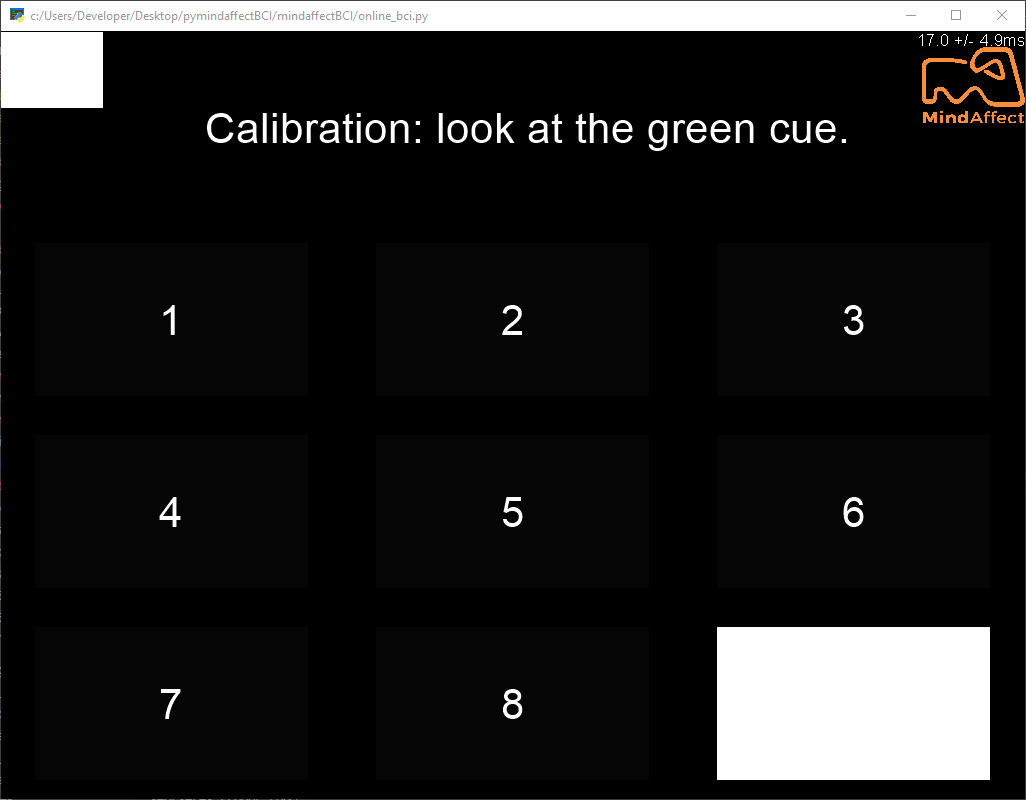

## Step 2: Run your BCI test run

After connecting the display to the amplifier.  The next stage is to run the BCI with the opto-resistor connected to get the timing data.  As we want to test the whole on-line processing loop we do this by simply running the full BCI stack, where basically the opto-resistor replaces the brain with a 'perfect' response brain.

To run the BCI we will use the `online_bci.py` script with the `trigger_check.json` configuration file.

### Note: if you do not have the EEG or opto-resistor hardware, you can simulate this run by using the `acquisation='fakedata'` option, which will use the fake-data EEG simulator, which also include a software trigger injector.

After the BCI has started:
* Press 0 to go to the signal viewer.  Here you can quickly check if your opto-resistor is working correctly by changing the display brightness and looking for the change in the appropriate EEG channel.
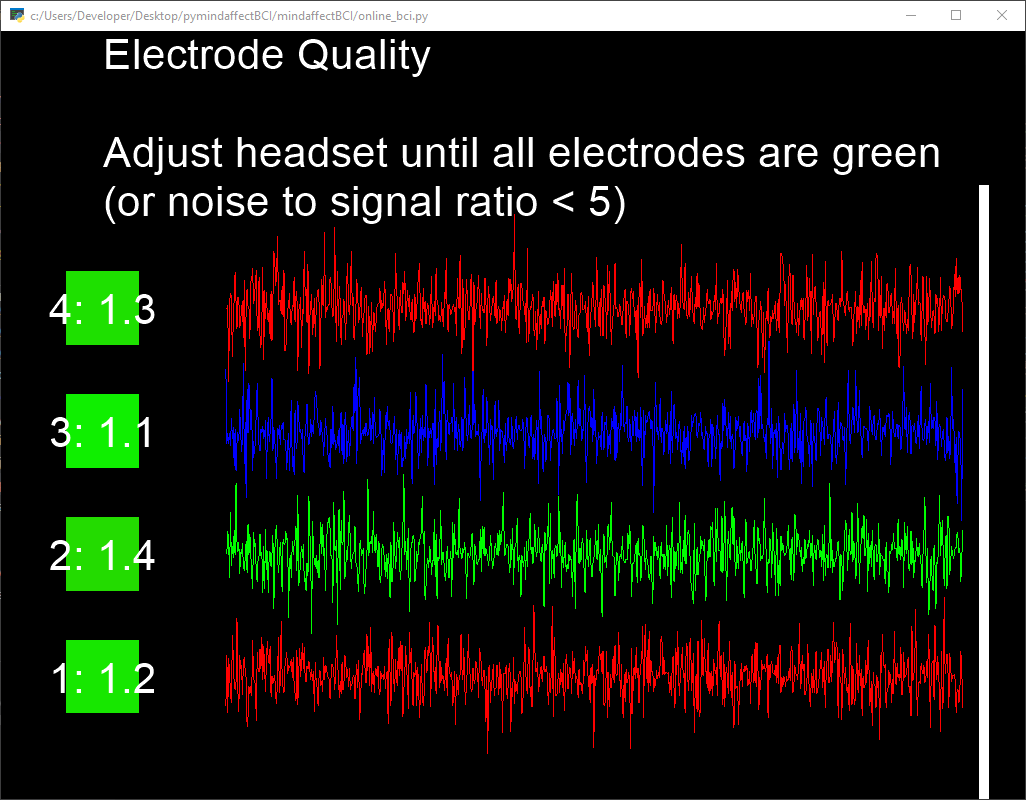
* Press a key to exit the signal viewer.
* Press 1 to enter cued calibration.  The system will now do 10 calibration trials of 4.2s each, and then fit the BCI model.  If your opto-resistor (and the BCI) is working correctly, it should tell you the *calibration performance was 100%*.
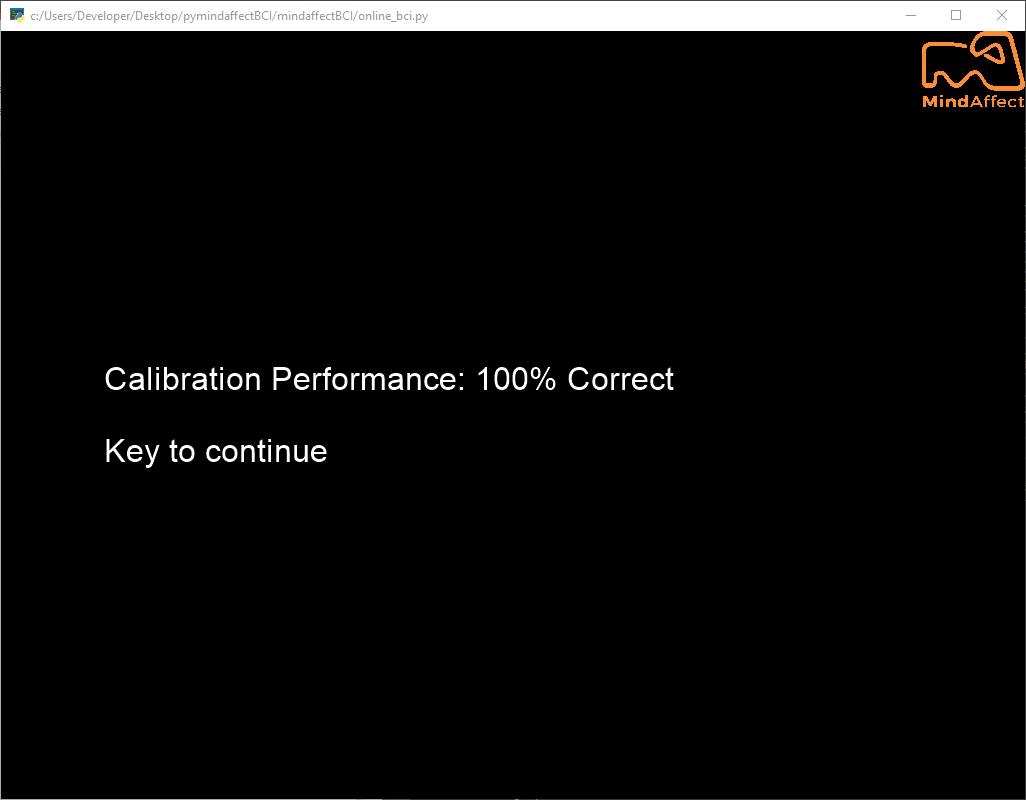
* Press a key to return to the main menu.  You can now press 2 to enter cued prediction if you wish, and test the trained BCI model.  Alternatively, as you have now got sufficient data for the time-lock analysis you can press q or escape to quit.

In [2]:
import mindaffectBCI.online_bci
# load the configuration file
config = mindaffectBCI.online_bci.load_config('trigger_check')

# for debugging with the fakedata source uncomment this line!
config['acquisation']='fakedata'

# run with the loaded configuration
mindaffectBCI.online_bci.run(**config)

Running command: ('java', '-jar', 'UtopiaServer.jar', '8400', '0', '../logs/mindaffectBCI_trigger_check.txt')
Starting fakedata
Electrode Quality (3600000ms)
stage transition
connecting screen
Not connected yet!!
Trying to auto-discover the utopia-hub server
making discovery object
Using inteface: 192.168.178.171
Got location: 192.168.178.171
.
.
Discovery returned 1 utopia-hub servers
Discovered utopia-hub on 192.168.178.171 ...
Tring to connect to: 192.168.178.171:-1
Trying to connect to: 192.168.178.171:8400
Connected!
NewSubscriptions: PSNMEQ
NewSubscriptions: MSPQ
stage transition
main menu
stage transition
Calibration instruct
stage transition
calibration
Start Cal: 0/10 tgtidx=3
tgtidx=3
flicker: 60 frames, tgt 3
highlight: tgtidx=3 nframes=60

1.wait
flicker: 60 frames, tgt -1
highlight: tgtidx=-1 nframes=60

2.stim, tgt:3
flicker: 252 frames, tgt 3

3.wait
flicker: 60 frames, tgt -1
highlight: tgtidx=-1 nframes=60


Start Cal: 1/10 tgtidx=4
tgtidx=4
flicker: 60 frames, tgt 4
h

## Step 3: Analysis the time-lock analysis data

If the above test ran correctly the system will have saved a data file in the `logs` directory of the project with a name like `mindaffectBCI_YYMMDD_HHMM.txt` containing all the information about your experiment.  This can be used for offline-analysis to explore and refine the model fitting process as explained in the [offline analysis tutorial](https://mindaffect-bci.readthedocs.io/en/latest/tutorials.html).

Here we will just to a trigger-check analysis.  For this we need to know which save file to load.  Fortunately, as a convience for this situation if we use the filename `-` the system will automatically load the most recent save file from the `logs` directory -- which is the one we just generated.

When this check runs it will generate 3 plots visualizing the trigger check data:

 1. *Trigger Check*:  This plot shows as an image the measured EEG response for every *stimulus onset* (i.e. when the stimuli gets brighter) for every trial.  This is displayed as an image where the vertical axis is time since the stimulus, and the horizontial axis are the onsets within each trial, with color showing the magnitude of the EEG.  This is the key plot for determing the timing accuracy.  
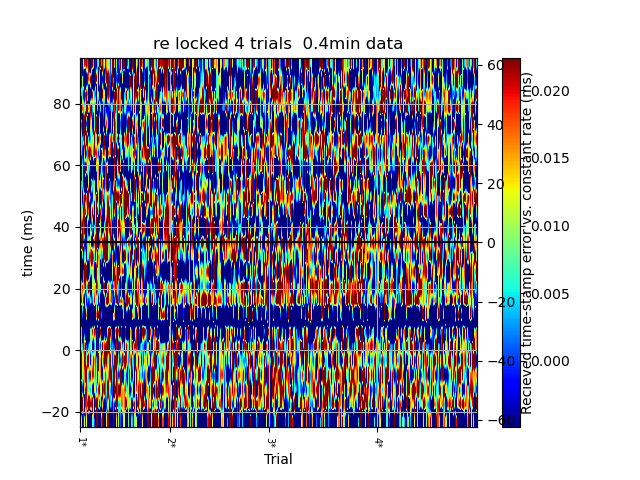
If your timing is accurate you should see a clear *horizontal* band at some time after 0ms -- here it's a blue line at about 10ms (in fact due to filtering artifacts you may see more than one such band).  By zooming in the y-axis you should see that:

  * the bands are *perfectly* horizontal, with no jitter.  If there is timing jitter you will see the start of the band move up and down between trials.  Here you can see there is a jitter of about +/-5ms -- which is 1 sample as the simulated amplifer runs at 200Hz.

  * the bands have no slope or steps.  Slopes imply that the stimulus timing is *drifting* with respect to the EEG measurments.  Steps imply the stimulus timing is suddenly increasing and decreasing in latency with respect to it's nomional time-stamp.  In particular we have noticed that steps are common for displays as the operating system (particularly windows) adds and removes frames from the graphics system to draw animations and blurs.

 2. *First Trials*:   This plot shows the raw time series for the first 3 trials of the saved data.  In addition it shows the stimulus data in `Y` (*black*) and predicted stimulus data generated by the fitted model in `wX`.  If your opto-resistor is working correctly you should clearly see the opto signal in the appropriate channel of X (channel 8 if using the cyton.)
 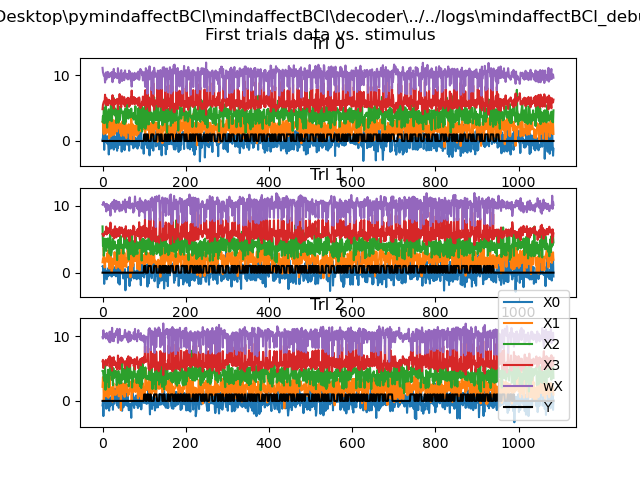

 3. *Classifier Model*.  This plot shows the parameters of the model trained by the classifier to identify the trigger response.  In particular the spatial pattern should match that of the opto-resistor channel if the model is correct.
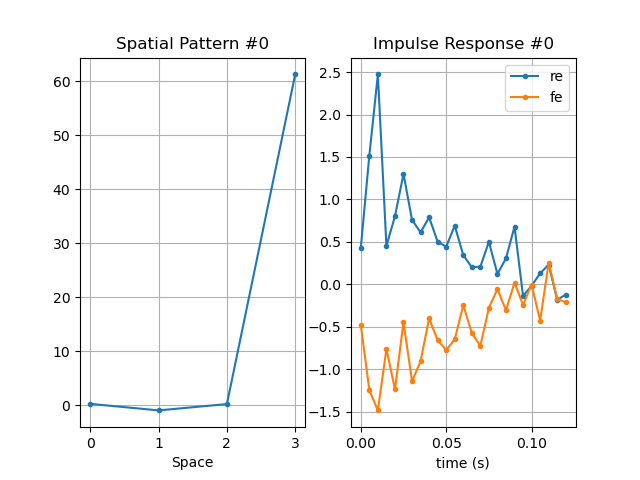 

Loading c:\users\developer\desktop\pymindaffectbci\mindaffectBCI\decoder\../../logs\mindaffectBCI_debug_201104_2207.txt
X=(9350, 4) @200.0Hz
preFilter: 6th butter (0.1, 45, 'bandpass')Hz & downsample 200.0->250Hz
resample: 200.0->200.0hz rsrate=1.0
Got 4 trials, keeping 4
4 trl_dur (samp): [1473 1463 1514]
4 trl_dur (ms) : [7367. 7316. 7567.]
slicing 4 trials =[-100 - 985] samples @ 200.0Hz
EEG: X(['trial', 'time', 'channel'])(4, 1085, 4) @200.0Hz
STIMULUS: Y(['trial', 'time', 'output'])(4, 1085, 10)
training model
Rank score: 1=0.993, 2=0.994, 3=0.994, 5=0.994 -> best=2
Sigma0 = 0.10911610769431285
softmaxscale=20
clsfr=MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=2, rcond=(0.0001, 1e-08), reg=(1e-08, None), symetric=False,
         tau=25)
applying spatial filter
W=[-0.00212799 -0.00069658  0.00016977 -0.02614203]
slicing data
generating plot
samp2ms=5.0


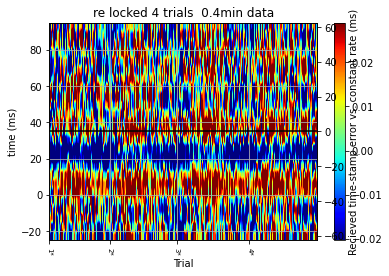

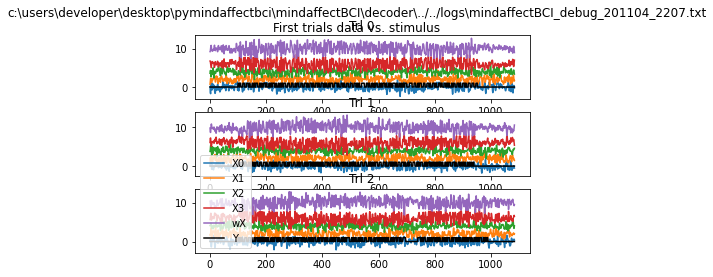

Plot Factored Model
A=(2, 4) R=(2, 2, 25)


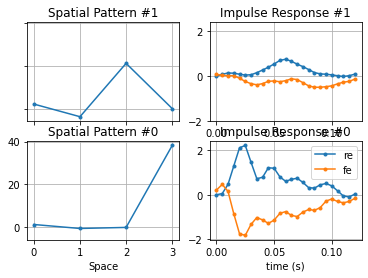

In [8]:
from mindaffectBCI.decoder.trigger_check import trigger_check
trigger_check('-')